In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import numpy as np
import scipy
import pandas as pd
import sqlalchemy as sa
sys.path.append(os.path.abspath(os.path.join('..','..','..')))
from pudl import init
from config import SETTINGS
import pudl.constants as pc
import pudl.extract.ferc1
import pudl.transform.ferc1
import pudl.output
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing.data import QuantileTransformer
from sklearn.preprocessing import scale
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn_pandas import DataFrameMapper
from sklearn_pandas import gen_features
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [3]:
plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = (10,6)
mpl.rcParams['figure.dpi'] = 150
pd.options.display.max_columns = 56

## Pull in the large FERC plants data and simplify it

In [4]:
pudl_engine = pudl.init.connect_db()
ferc1_engine = pudl.extract.ferc1.connect_db()
ferc1_steam = pd.read_sql('SELECT * FROM f1_steam;', ferc1_engine)

In [5]:
# Vectorizing the DataFrame with a pre-processing function:
ferc1_steam_clean, fpv = pudl.transform.ferc1.vectorize_plants(ferc1_steam, ngram_range=(2,10))

In [6]:
[ (k,f.shape) for k,f in fpv.items() ]

[('plant_kind_clean', (11419, 7)),
 ('respondent_id', (11419, 135)),
 ('yr_const', (11419, 103)),
 ('row_number', (11419, 5)),
 ('spplmnt_num', (11419, 9)),
 ('tot_capacity', (11419, 1)),
 ('plant_name', (11419, 37512))]

In [7]:
# Vectorizing the DataFrame using sklearn_pandas
cat_feat_map = gen_features(
    columns=['plant_kind_clean', 'respondent_id', 'yr_const', 'row_number', 'spplmnt_num'],
    classes=[LabelBinarizer]
)
str_feat_map = [('plant_name', TfidfVectorizer(analyzer='char', ngram_range=(2,10)))]
num_feat_map = [(['tot_capacity'], MinMaxScaler())]
ferc_feat_map = cat_feat_map + str_feat_map + num_feat_map
ferc_mapper = DataFrameMapper(ferc_feat_map, sparse=True)
fmv = ferc_mapper.fit_transform(ferc1_steam_clean)

In [8]:
# Vectorizing the DataFrame using Transformer classes:
ferc_pipe = Pipeline([
    
    # Use FeatureUnion to combine the features from subject and body
    ('union', FeatureUnion(
        transformer_list=[

            # Pipeline for vectorizing a FERC plant name using TF-IDF on character n-grams
            ('plant_name', Pipeline([
                ('selector', pudl.transform.ferc1.ColumnSelector(key='plant_name')),
                ('tfidf', TfidfVectorizer(analyzer='char', ngram_range=(2,5))),
                ('norm', Normalizer())
            ])),

            ('respondent_id', Pipeline([
                ('selector', pudl.transform.ferc1.ColumnSelector(key='respondent_id')),
                ('lb', pudl.transform.ferc1.LabelBinarizerPipelineFriendly()),
                ('norm', Normalizer())
            ])),
            
            ('plant_kind', Pipeline([
                ('selector', pudl.transform.ferc1.ColumnSelector(key='plant_kind_clean')),
                ('lb', pudl.transform.ferc1.LabelBinarizerPipelineFriendly()),
                ('norm', Normalizer())
            ])),
            
            ('yr_const', Pipeline([
                ('selector', pudl.transform.ferc1.ColumnSelector(key='yr_const')),
                ('lb', pudl.transform.ferc1.LabelBinarizerPipelineFriendly()),
                ('norm', Normalizer())
            ])),
            
#            ('row_number', Pipeline([
#                ('selector', pudl.transform.ferc1.ColumnSelector(key='row_number')),
#                ('lb', pudl.transform.ferc1.LabelBinarizerPipelineFriendly()),
#                ('norm', Normalizer())
#            ])),

#            ('spplmnt_num', Pipeline([
#                ('selector', pudl.transform.ferc1.ColumnSelector(key='spplmnt_num')),
#                ('lb', pudl.transform.ferc1.LabelBinarizerPipelineFriendly()),
#                ('norm', Normalizer())
#            ])),

#           ('tot_capacity', Pipeline([
#               ('selector', pudl.transform.ferc1.pipelinize_feature(pudl.transform.ferc1.ColumnSelector(key='tot_capacity'))),
#               ('scaler', QuantileTransformer(output_distribution='normal')),
#               ('norm', Normalizer())
#           ])),
#
        ],

        # weight components in FeatureUnion
        transformer_weights={
            'plant_name': 1.0,
            'respondent_id': 1.0,
            'plant_kind_clean': 1.0,
            'tot_capacity': 0.5,
            'yr_const': 0.5,
            'row_number': 0.2,
            'spplmnt_num': 0.2,
        },
    )), # end feature union
    
    ('clf', pudl.transform.ferc1.FERCPlantClassifier(min_sim=0.9, plants_df=ferc1_steam_clean))
    
]) # end pipeline

In [9]:
fpo = ferc_pipe.fit_transform(ferc1_steam_clean)

/home/zane/anaconda3/envs/pudl/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [10]:
plant_groups = fpo.predict(fpo.best_of_.record_id.values)
# Why do we get nothing back when there are any NaN values?

In [11]:
plant_group_sizes = pd.Series([len(g) for g in plant_groups])

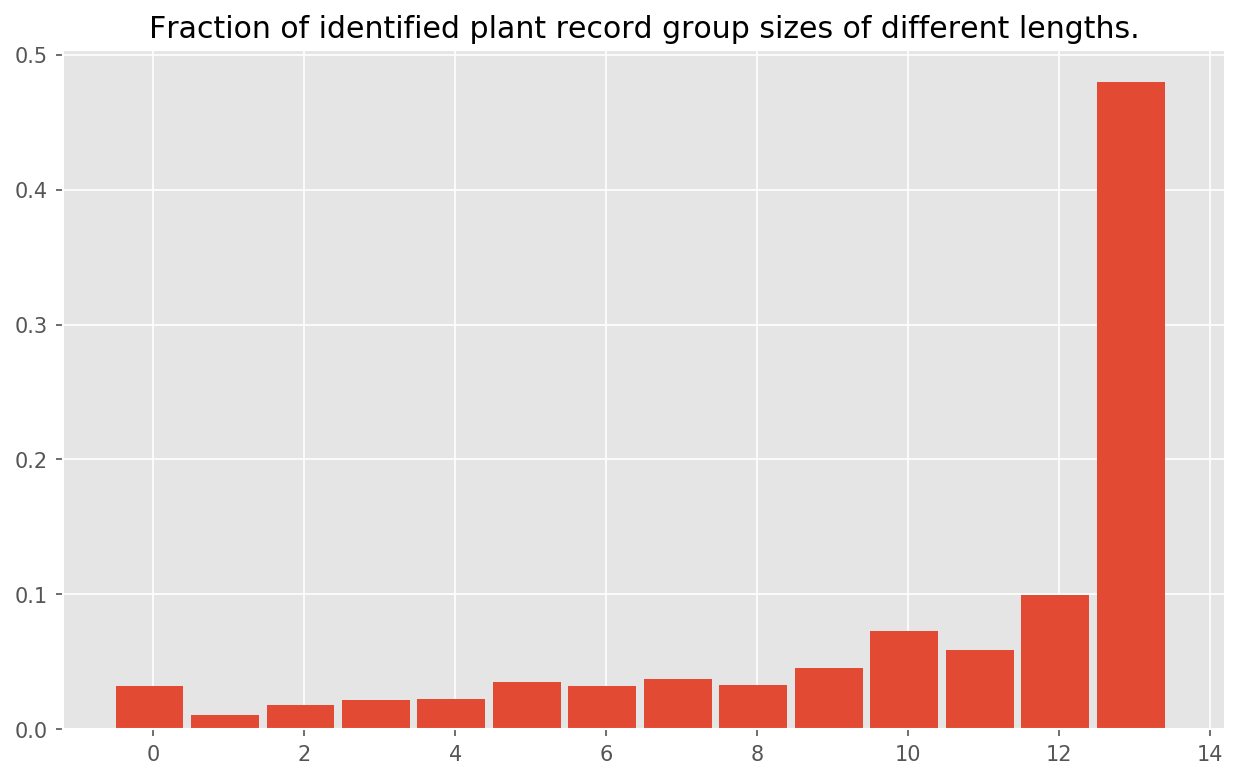

In [12]:
plt.hist(plant_group_sizes, bins=np.arange(-0.5,14.5), density=True, align='mid', width=0.9)
plt.title('Fraction of identified plant record group sizes of different lengths.');

In [13]:
random_group = np.random.choice(plant_groups)
features = [
    'record_id',
    'respondent_id',
    'plant_name',
    'plant_kind_clean',
    'tot_capacity',
    'yr_const'
]
ferc1_steam_clean[ferc1_steam_clean.record_id.isin(random_group)][features]

,record_id,respondent_id,plant_name,plant_kind_clean,tot_capacity,yr_const
2022,2006_178_0_2,178,miami fort 6,steam,168.0,1960
2939,2007_178_0_2,178,miami fort 6,steam,168.0,1960
4221,2008_178_0_2,178,miami fort 6,steam,168.0,1960
4530,2009_178_0_2,178,miami fort 6,steam,168.0,1960
5770,2010_178_0_2,178,miami fort 6,steam,168.0,1960
6595,2011_178_0_2,178,miami fort 6,steam,168.0,1960
7417,2012_178_0_2,178,miami fort 6,steam,168.0,1960
8304,2013_178_0_2,178,miami fort 6,steam,168.0,1960
9272,2014_178_0_2,178,miami fort 6,steam,168.0,1960
10504,2015_178_0_2,178,miami fort 6,steam,168.0,1960
